<a href="https://colab.research.google.com/github/Youhanna-Yousry/Face-Recognition/blob/master/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition


## Problem statement
We intend to perform face recognition. Face recognition means that for a given image you can tell the subject id. Our database of subject is very simple. It has 40 subjects. Below we will show the needed steps to achieve the goal of the assignment. ([assignment link](https://github.com/Youhanna-Yousry/Face-Recognition/blob/master/assets/CSE352_Assignment_1.pdf))

## Imports

In [ ]:
import os
import numpy as np
import re
import cv2
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as PCA_Randomized
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as Shrinkage_LDA
import pandas as pd
import time

## 1.Downloading the dataset and understanding its format
Credits to AT&T Laboratories Cambridge.
The data set contains 40 different subject each has 10 grayscale images of size 92x112.
Images are saved in PGM format (stands for Portable Gray Map) and each pixel has a value between 0 and 255. ([ORL database of faces link ](https://www.kaggle.com/datasets/kasikrit/att-database-of-faces))

In [ ]:
# kaggle api setup

!pip install -q kaggle

from google.colab import files

files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

# downloading faces dataset

!kaggle datasets download -d kasikrit/att-database-of-faces
!unzip archive.zip -d /faces-dataset

Saving kaggle.json to kaggle.json
ref                                                        title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide       Covid Cases and Deaths WorldWide              8KB  2023-02-01 12:22:51          10437        344  1.0              
datascientistanna/customers-dataset                        Shop Customer Data                           23KB  2023-02-07 18:42:21           8852        205  1.0              
justin2028/unemployment-in-america-per-us-state            Unemployment in America, Per US State       826KB  2023-03-02 07:26:03            859         46  1.0              
anas123siddiqui/mobiles                                    Mobiles                         

Downloading faces-dataset from Google Drive and extracting them into root directory of Colab notebook

In [ ]:
!gdown  https://drive.google.com/uc?id=1jpCPSCpBMZyYXj_YrqHNVZDr0Tlx3jdq && unzip archive.zip -d /faces-dataset

Downloading...
From: https://drive.google.com/uc?id=1jpCPSCpBMZyYXj_YrqHNVZDr0Tlx3jdq
To: /content/archive.zip
100% 3.78M/3.78M [00:00<00:00, 218MB/s]
Archive:  archive.zip
  inflating: /faces-dataset/README   
  inflating: /faces-dataset/s1/1.pgm  
  inflating: /faces-dataset/s1/10.pgm  
  inflating: /faces-dataset/s1/2.pgm  
  inflating: /faces-dataset/s1/3.pgm  
  inflating: /faces-dataset/s1/4.pgm  
  inflating: /faces-dataset/s1/5.pgm  
  inflating: /faces-dataset/s1/6.pgm  
  inflating: /faces-dataset/s1/7.pgm  
  inflating: /faces-dataset/s1/8.pgm  
  inflating: /faces-dataset/s1/9.pgm  
  inflating: /faces-dataset/s10/1.pgm  
  inflating: /faces-dataset/s10/10.pgm  
  inflating: /faces-dataset/s10/2.pgm  
  inflating: /faces-dataset/s10/3.pgm  
  inflating: /faces-dataset/s10/4.pgm  
  inflating: /faces-dataset/s10/5.pgm  
  inflating: /faces-dataset/s10/6.pgm  
  inflating: /faces-dataset/s10/7.pgm  
  inflating: /faces-dataset/s10/8.pgm  
  inflating: /faces-dataset/s10/9.pgm

Downloading fruits-dataset for "faces vs non-faces part" from Google Drive and extracting them into root directory of Colab noteboo

In [ ]:
!gdown  https://drive.google.com/uc?id=139V9a9wSMW3fnrRpVtWDaGZmmeBfoFqC && unzip archive2.zip -d /non-faces-dataset

Downloading...
From: https://drive.google.com/uc?id=139V9a9wSMW3fnrRpVtWDaGZmmeBfoFqC
To: /content/archive2.zip
100% 15.7M/15.7M [00:00<00:00, 102MB/s] 
Archive:  archive2.zip
replace /non-faces-dataset/1/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## 2.Generating the Data Matrix and the Label vector

* Listing all directories that contain the faces of each person in the "faces-dataset".
* Reading grayscale images of faces from each directory using the cv2.imread function from the cv2 library.
* Converting each image into a row vector of 10304 features.
* Adding each row vector to the data matrix.
* Assigning a label to each row vector and adding it to the label vector





In [ ]:
def generate_data_and_label(dataset_dir):
  '''
  Generates the data matrix and the label vector from the given dataset
  directory.

  Args:
    dataset_dir (str): the directory of the datasest (must have a folder
    containing images for each subject).

  Returns:
    Tuple of numpy array representing the data matrix and label vector.

  '''
  current_dir = ''

  data_matrix = []
  label_vector = []

  # removes the first character of the string and converts the rest to integer
  # if it's not a number returns infinity
  get_subject_number = lambda x: int(x[1:]) if x[1:].isdigit() else float('inf')

  # finds the first number in the string
  get_image_number = lambda x: int(re.findall('\d+', x)[0])

  for dir in sorted(os.listdir(dataset_dir), key = get_subject_number):
    current_dir = os.path.join(dataset_dir, dir)
    if os.path.isfile(current_dir):
      continue
    current_subject = get_subject_number(dir)
    for img in sorted(os.listdir(current_dir), key = get_image_number):
      image_path = os.path.join(current_dir, img)
      image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
      data_matrix.append(np.array(image).flatten())
      label_vector.append(current_subject)

  # converting lists to numpy array
  data_matrix = np.array(data_matrix)
  label_vector = np.array(label_vector)

  return data_matrix, label_vector

In [ ]:
data_matrix, label_vector = generate_data_and_label('/faces-dataset')



*   Same process as before for the fruits dataset
*   We read faces dataset and assign them to label 1 and
* We read the fuits dataset in a grayscale format and resize the images to be 92 * 112 using cv2.INTER_AREA interpolation method
* Each fruit sample is assigned to label 2
* We use data_size to select how many samples we are going to use from the fruits dataset



In [ ]:
def generate_data_and_label_face_non_face(face_dataset_dir, non_face_dataset_dir, data_size):

  current_dir = ''

  data_matrix = []
  label_vector = []

  faces_paths = []
  non_faces_paths = []

  get_subject_number = lambda x: int(x[1:]) if x[1:].isdigit() else float('inf')

  get_image_number = lambda x: int(re.findall('\d+', x)[0])

  for dir in sorted(os.listdir(face_dataset_dir), key = get_subject_number):
    current_dir = os.path.join(face_dataset_dir, dir)
    if os.path.isfile(current_dir):
      continue
    for img in sorted(os.listdir(current_dir), key = get_image_number):
      image_path = os.path.join(current_dir, img)
      faces_paths.append(image_path)
      image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
      data_matrix.append(np.array(image).flatten())
      label_vector.append(1)

  for dir in sorted(os.listdir(non_face_dataset_dir), key = get_image_number):
    current_dir = os.path.join(non_face_dataset_dir, dir)
    if os.path.isfile(current_dir):
      continue
    i=0
    for img in sorted(os.listdir(current_dir), key = get_image_number):
      image_path = os.path.join(current_dir, img)
      non_faces_paths.append(image_path)
      image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
      resized_image = cv2.resize(image, (92, 112), interpolation = cv2.INTER_AREA)
      data_matrix.append(np.array(resized_image).flatten())
      label_vector.append(2)
      i += 1
      if i == data_size//5 :
        break

  # converting lists to numpy array
  data_matrix = np.array(data_matrix)
  label_vector = np.array(label_vector)

  return data_matrix, label_vector, faces_paths, non_faces_paths

In [ ]:
face_non_face_dataset, face_non_face_label_vector, faces_test_indecies, fruits_test_indecies = generate_data_and_label_face_non_face('/faces-dataset', '/non-faces-dataset', 400)

## 3.Spliting the Dataset into Training and Test sets



*   In this part we split the faces data matrix where odd samples are used for training and odd samples are used for testing
* We split the label vector accordingly



In [ ]:
def split_dataset(data_matrix, label_vector, mask):

  training_data_matrix = data_matrix[mask]
  training_label_vector = label_vector[mask]

  testing_data_matrix = data_matrix[~mask]
  testing_label_vector = label_vector[~mask]

  return training_data_matrix, training_label_vector, \
   testing_data_matrix, testing_label_vector

In [ ]:
training_data, training_labels, testing_data, testing_labels = split_dataset(data_matrix, label_vector,
                                                                             np.arange(data_matrix.shape[0]) % 2 == 1)

## 4.Classification using PCA




*   This class for PCA is used to apply the PCA algorithm and compute the projection matrix for the given training data.


**Attributes:**


*   eigen_vectors:     Ordered directions based on their explained variance and the top k of them are selected for dimensionality reduction
*   cumulative_sum:    array used to store the cumulative sum of the sorted eigen values and used to select the top components required for given alpha


**Methods:**


*   fit(data_matrix): takes the training data as input and used to generate the projection matrix by computing the covariance matrix and computing its eigen values and eigen vectors
*   project_data(data_matix, alpha): used to project the given data by selecting the top eigen vectors that store the maxmimum variation for a given alpha and return the projected data





In [ ]:
class PCA:
  def __init__(self):
    self.eigen_vectors = None
    self.cumulative_sum = None

  def fit(self, data_matrix):
    # centering the data
    mean_vector = np.mean(data_matrix, axis=0)
    centered_matrix = data_matrix - mean_vector

    # computing the covariance matrix
    covariance_matrix = np.cov(centered_matrix, rowvar=False, bias=True)

    # computing eigen values and eigen vectors
    eigen_values, self.eigen_vectors = np.linalg.eigh(covariance_matrix)

    # reversing the order of eigen values and eigen vectors
    eigen_values = eigen_values[::-1]
    self.eigen_vectors = self.eigen_vectors[:, ::-1]

    # computing the cumulative sum of eigen values
    self.cumulative_sum = np.cumsum(eigen_values)

  def project_data(self, data_matrix, alpha):
    if self.eigen_vectors is None:
      raise ValueError("PCA object needs to be fitted first!")

    threshold = alpha * self.cumulative_sum[-1]
    idx = np.argmax(self.cumulative_sum >= threshold)
    return np.dot(data_matrix, self.eigen_vectors[:, :idx+1])

* This method used KNN to classify the given training data and labels and the given based on the given number of neighbours
* Then it makes prediction for the given testing data and computes the accuracy
* returns both the prediction and the accuracy



In [ ]:
def classifier(neighbours, training_data, training_labels, testing_data, testing_labels):

  classifier = KNeighborsClassifier(neighbours)
  classifier.fit(training_data, training_labels)

  prediction = classifier.predict(testing_data)

  accuracy = len(prediction[prediction == testing_labels]) / len(prediction)

  return prediction, accuracy



*   This method is used to compute the accuracy of PCA using the given training and testind data for different values of alphas
*   Plot the relation between alpha and the accuracy of PCA





In [ ]:
def compute_accuracy_for_alphas(pca, training_data, training_labels, testing_data, testing_labels, alphas):
  accuracies = []

  for alpha in alphas:
    projected_training_data = pca.project_data(training_data, alpha)
    projected_testing_data = pca.project_data(testing_data, alpha)
    _, accuracy = classifier(1, projected_training_data, training_labels,
                              projected_testing_data, testing_labels)

    accuracies.append(accuracy)

  plt.plot(alphas, accuracies)
  plt.xlabel('Alpha')
  plt.ylabel('Accuracy')
  plt.title('Relationship between Alpha and Accuracy')
  plt.show()

In this part, we run the PCA algorithm with the trainging data of faces and compute the accuracy for a given testing data while changing alpha

We plot the relation between the accuracy and selected alpha

In [ ]:
pca = PCA()
pca.fit(training_data)

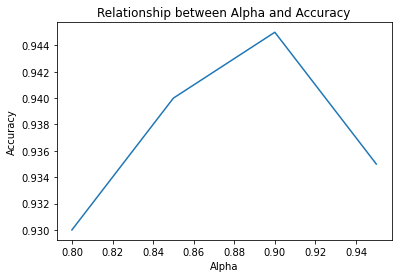

In [ ]:
compute_accuracy_for_alphas(pca, training_data, training_labels, testing_data, testing_labels,
                            [0.8, 0.85, 0.9, 0.95])

We can notice that when alpha increases the accuracy increases until certain threshold after that, it decreases because of the overfitting problem (since the variance is greater when we take more principal components of the training data therefore, the clustering is not often precise)

## 5.Classification Using LDA



*   This class for LDA is used to apply the LDA algorithm and compute the projection matrix for the given training data.

* It is generalized to compute projection that maximize the separation between 2 class or multiclasses where the algorithm changes based on the number of classes in the labels provided



**Attributes:**

* eigen_values: The ordered eigen values that represent the variation kept by each direction and used to sort their corresponding eigen vectors

*   eigen_vectors:     Ordered directions based on their explained variance and the top k of them are selected

* projection_matrix: used to project the given data in the directions that maximize the separation between classes and reduce the variance within each class


**Methods:**


*   fit(data_matrix, labels, components):

takes the training data and training labels as inputs and used to generate the projection matrix.


The algorithm for computing the projection matrix changes based on the number of classes in the given labels


 If the number of components is not given it will return the all eigen vectors


*   project_data(data):


used to project the given data by using the computed projection matrix





In [ ]:
class LDA:

  def __init__(self) -> None:
    self.eigen_values =  None
    self.eigen_vectors = None
    self.projection_matrix = None
    pass


  def fit(self, data_matrix, labels, components=-1):

    classes_number = len(np.unique(labels))

    class_subsets = np.array([data_matrix[labels == i] for i in range(1, classes_number + 1)])

    means = np.array([np.mean(class_subsets[i], axis=0) for i in range(len(class_subsets))])

    sb = np.zeros((data_matrix.shape[1], data_matrix.shape[1]))

    if classes_number > 2 :

      overall_sample_mean = np.mean(means, axis=0)

      centered_means = (means - overall_sample_mean).reshape(len(np.unique(labels)), 1, data_matrix.shape[1])

      for x in range(len(centered_means)):

        mult = np.dot(np.transpose(centered_means[x]), centered_means[x]) * len(class_subsets[x])
        sb = np.sum([sb, mult], axis=0)

    else:

        sb = np.dot((means[0] - means[1]).reshape(-1, 1), (means[0] - means[1]).reshape(1, -1))

    centered_classes = np.array([class_subsets[i] - means[i] for i in range(len(means))])

    within_class_scatter = np.zeros((data_matrix.shape[1], data_matrix.shape[1]))

    for x in range(len(centered_classes)):

      mult = np.dot(np.transpose(centered_classes[x]), centered_classes[x])
      within_class_scatter = np.sum([within_class_scatter, mult], axis=0)

    self.eigen_values, self.eigen_vectors = linalg.eig(np.dot(linalg.pinv(within_class_scatter), sb))

    self.eigen_values = np.real(self.eigen_values)
    self.eigen_vectors = np.real(self.eigen_vectors)

    idx = np.argsort(self.eigen_values)[::-1]
    self.eigen_values = self.eigen_values[idx]
    self.eigen_vectors = self.eigen_vectors[:, idx]

    self.projection_matrix = self.eigen_vectors[:, :components] if components != -1 else self.eigen_vectors

    return self.projection_matrix


  def project_data(self, data):

    projected_data = np.dot(data, self.projection_matrix )

    return projected_data


  def projection_matrix(self):
    return self.projection_matrix

Reporting the accuracy for Multi-Classes LDA

In [ ]:
lda = LDA()
lda.fit(training_data, training_labels, 39)
print('Accuracy:\t', classifier(1, lda.project_data(training_data), training_labels,
                 lda.project_data(testing_data), testing_labels))

Accuracy:	 (array([16,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14,
       14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21,
       21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24,
       24, 25, 25, 25, 25, 25, 26,  3, 26, 37, 26, 27, 27, 27, 27, 27, 28,
       28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31,
       21, 31, 32, 32, 32,  2, 32, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34,
       35, 35, 35, 35, 35, 36, 36,  7, 36, 36, 37, 37, 37, 37, 37, 38, 38,
       38, 38, 23, 39, 39, 39, 39, 39, 40, 40, 40, 40,  5]), 0.96)


For the faces dataset, the LDA always has better accuracy than PCA because its objective is to maximize the separation between classes and decraeses each class variance. Therefore, it's better in classification

## 6.Classifier Tuning



*   This function takes trained PCA and LDA and directly uses the projection matrices to transform the training matrices and compute the accuracy for different ks.
*   Then, it plots a line plot that describe the relation between k and accuracy (for both LDA and PCA).



In [ ]:
def compute_accuracy_for_ks(pca, lda, training_data, training_labels, testing_data, testing_labels, ks):

  def compute_accuracies(projected_training_data, projected_testing_data):
    accuracies = []
    for k in ks:
        _, accuracy = classifier(k, projected_training_data, training_labels, projected_testing_data, testing_labels)
        accuracies.append(accuracy)
    return accuracies

  pca_projected_training_data = pca.project_data(training_data, 0.95)
  pca_projected_testing_data = pca.project_data(testing_data, 0.95)

  lda_projected_training_data = lda.project_data(training_data)
  lda_projected_testing_data = lda.project_data(testing_data)

  pca_accuracies = compute_accuracies(pca_projected_training_data, pca_projected_testing_data)
  lda_accuracies = compute_accuracies(lda_projected_training_data, lda_projected_testing_data)

  plt.plot(ks, pca_accuracies, label='pca')
  plt.plot(ks, lda_accuracies, label='lda')

  plt.legend()
  plt.xlabel('K')
  plt.ylabel('Accuracy')

  plt.title('Relationship between K and Accuracy')

  plt.show()

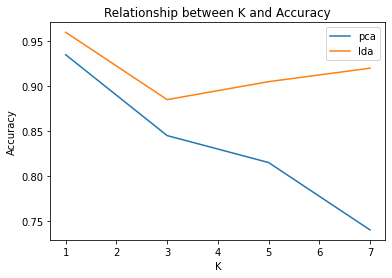

In [ ]:
compute_accuracy_for_ks(pca, lda, training_data, training_labels, testing_data, testing_labels, [1, 3, 5, 7])

Since LDA objective is to maximize the separation between classes threfore, it seems to be not affected too much by the K value in this dataset.
On the other side, when increasing the k in PCA the accuracy decreases because the classes are not grouped together.

## 7.Compare vs Non-Face Images



*   This funciton filters the required classes.
*   Then, the data is splitted to training set and testing set.



In [ ]:
def face_non_face_split(data_set, labels, train_size, required_label):

  filtered_labels = labels == required_label

  x = pd.DataFrame(data_set[filtered_labels])
  y = pd.Series(labels[filtered_labels])

  x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = train_size)

  return x_train, x_test, y_train, y_test


The paths of the faces test set are stored in **faces_test_indecies** in order to detect the success and failure cases.

In [ ]:
face_training_data, face_testing_data, face_training_labels, face_testing_labels = face_non_face_split(face_non_face_dataset, face_non_face_label_vector, 0.7, 1)

faces_test_indecies = np.array(faces_test_indecies)[face_testing_data.index.tolist()]



*   Groups the training data of faces and non faces then
*   It uses the LDA to project data into the direction that best descriminates the classes
*   KNN classifier is then used to perform the classification and predicts the labels of test data of faces and non faces.
*   Finally, the function returns the accuracy and the prediciton.



In [ ]:
def face_non_face_calssification(face_training_data, face_testing_data, face_training_labels, face_testing_labels, train_size):

  global fruits_test_indecies

  non_face_training_data, non_face_testing_data, non_face_training_labels, non_face_testing_labels =  \
    face_non_face_split(face_non_face_dataset, face_non_face_label_vector, train_size, 2)

  fruits_test_indecies = np.array(fruits_test_indecies)[non_face_testing_data.index.tolist()]

  face_non_face_training_data = np.append(face_training_data.values, non_face_training_data.values, axis=0)
  face_non_face_training_labels = np.append(face_training_labels.values, non_face_training_labels.values)
  face_non_face_testing_data = np.append(face_testing_data.values, non_face_testing_data.values, axis=0)
  face_non_face_testing_labels = np.append(face_testing_labels.values, non_face_testing_labels.values)

  lda = LDA()

  lda.fit(face_non_face_training_data, face_non_face_training_labels, 1)

  p_training_data = lda.project_data(face_non_face_training_data)

  p_testing_data = lda.project_data(face_non_face_testing_data)

  prediction, accuracy = classifier(1, p_training_data, face_non_face_training_labels, p_testing_data, face_non_face_testing_labels)

  return prediction, accuracy


*   Takes the preciciton and returns the image pathes of success and fail cases.



In [ ]:
def check_success_failure(prediction, faces_test_indecies, fruits_test_indecies):

  success, fail = [], []

  for i in range(0, 120):
    if prediction[i] == 1:
      success.append(faces_test_indecies[i])
    else:
       fail.append(faces_test_indecies[i])

  for i in range(120, len(prediction)):
    if prediction[i] == 2:
      success.append(fruits_test_indecies[i - 120])
    else:
       fail.append(fruits_test_indecies[i - 120])

  return success, fail

In [ ]:
prediction, accuracy = face_non_face_calssification(face_training_data, face_testing_data, face_training_labels, face_testing_labels, 0.7)
print("Prediction and Accuray:\t", prediction, accuracy)

success, fail = check_success_failure(prediction, faces_test_indecies, fruits_test_indecies)

print("Success cases:\t", success)
print("Failed cases:\t", fail)

Prediction and Accuray:	 [1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 1 1 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 1 1 2 2 2 1 2 2 2] 0.925
Success cases:	 ['/faces-dataset/s21/4.pgm', '/faces-dataset/s29/9.pgm', '/faces-dataset/s30/3.pgm', '/faces-dataset/s16/3.pgm', '/faces-dataset/s32/9.pgm', '/faces-dataset/s2/9.pgm', '/faces-dataset/s37/10.pgm', '/faces-dataset/s15/5.pgm', '/faces-dataset/s34/3.pgm', '/faces-dataset/s26/2.pgm', '/faces-dataset/s32/6.pgm', '/faces-dataset/s24/6.pgm', '/faces-dataset/s27/5.pgm', '/faces-dataset/s13/4.pgm', '/faces-dataset/s12/6.pgm', '/faces-dataset/s13/9.pgm', '/faces-dataset/



*   Plots the accuracy of classification when fixing faces data and increasing the size of non faces data.



Accuracy for 400:	 0.925


<ipython-input-13-cd9bb42c7add>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  class_subsets = np.array([data_matrix[labels == i] for i in range(1, classes_number + 1)])
<ipython-input-13-cd9bb42c7add>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centered_classes = np.array([class_subsets[i] - means[i] for i in range(len(means))])


Accuracy for 520:	 0.925


<ipython-input-13-cd9bb42c7add>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  class_subsets = np.array([data_matrix[labels == i] for i in range(1, classes_number + 1)])
<ipython-input-13-cd9bb42c7add>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centered_classes = np.array([class_subsets[i] - means[i] for i in range(len(means))])


Accuracy for 640:	 0.9291666666666667


<ipython-input-13-cd9bb42c7add>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  class_subsets = np.array([data_matrix[labels == i] for i in range(1, classes_number + 1)])
<ipython-input-13-cd9bb42c7add>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centered_classes = np.array([class_subsets[i] - means[i] for i in range(len(means))])


Accuracy for 760:	 0.9041666666666667


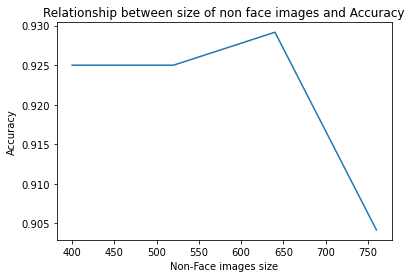

In [ ]:
accuracies = []

for x in range(400, 800, 120):

  global face_non_face_dataset, face_non_face_label_vector, fruits_test_indecies

  face_non_face_dataset, face_non_face_label_vector, _, fruits_test_indecies = generate_data_and_label_face_non_face('/faces-dataset', '/non-faces-dataset', x)

  prediction, accuracy = face_non_face_calssification(face_training_data, face_testing_data, face_training_labels, face_testing_labels, (x - 120)/(float)(x))

  print("Accuracy for " + str(x) + ":\t", accuracy)

  accuracies.append(accuracy)

plt.plot(np.arange(400, 800, 120), accuracies)
plt.xlabel('Non-Face images size')
plt.ylabel('Accuracy')
plt.title('Relationship between size of non face images and Accuracy')
plt.show()


At first the accuracy tends to be improved slightly then it decreases and this is because that the class with the more samples "Non-faces" affect the decision boundary and bias the classification towards it and the classifier tends to predict non faces more than faces which will decrease the accuracy



## 8.Bonus

#### a) Different Training and Test splits



*   The accuracy is computed using different split; instead of 50-50 we increased the size of training data to be 70.



In [ ]:
training_data, training_labels, testing_data, testing_labels = split_dataset(data_matrix, label_vector,
                                                                             np.arange(data_matrix.shape[0]) % 10 < 7)

In [ ]:
pca.fit(training_data)

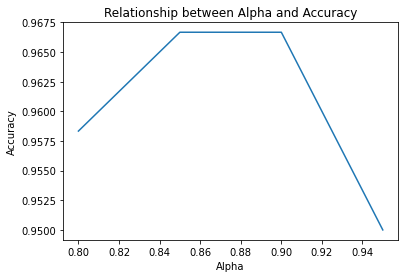

In [ ]:
compute_accuracy_for_alphas(pca, training_data, training_labels, testing_data, testing_labels,
                            [0.8, 0.85, 0.9, 0.95])



 The accuracy of pca improved when using more training data.



In [ ]:
lda.fit(training_data, training_labels, 39)

array([[-0.00431265,  0.00120864, -0.00490706, ..., -0.00431158,
         0.0037851 ,  0.00329748],
       [-0.00031091, -0.00105019, -0.00707077, ..., -0.00092244,
         0.0033981 , -0.0006664 ],
       [-0.00046923, -0.00203809, -0.00604414, ..., -0.00122868,
         0.00617534,  0.00036863],
       ...,
       [ 0.02348746,  0.00689234, -0.01550597, ..., -0.00498221,
         0.01517272, -0.00502765],
       [ 0.02082171,  0.01065187, -0.00321983, ...,  0.00311702,
        -0.00207084, -0.00581951],
       [ 0.01898468,  0.00713215,  0.00400228, ...,  0.01263888,
        -0.00525256, -0.00287767]])

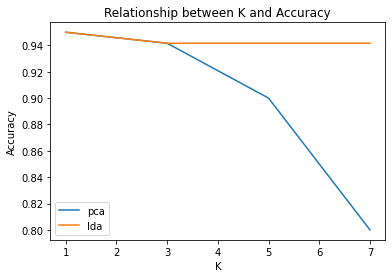

In [ ]:
compute_accuracy_for_ks(pca, lda, training_data, training_labels, testing_data, testing_labels, [1, 3, 5, 7])



 Both PCA and LDA accuracies have increased and LDA is almost not affected by changing the K. On the other side, the PCA accuracy is dramatically affected by increasing the size of K.



#### b) Varaiton of PCA and LDA

In [ ]:
training_data, training_labels, testing_data, testing_labels = split_dataset(data_matrix, label_vector,
                                                                             np.arange(data_matrix.shape[0]) % 2 == 1)


1.   **Randomized PCA:** [Geeks for geeks article](https://www.geeksforgeeks.org/python-variations-of-principal-component-analysis/)

    Randomized PCA is a variation of Principal Component Analysis (PCA) that is designed to approximate the first k principal components of a large dataset efficiently. Instead of computing the eigenvectors of the covariance matrix of the data, as is done in traditional PCA, randomized PCA uses a random projection matrix to map the data to a lower-dimensional subspace. The first k principal components of the data can then be approximated by computing the eigenvectors of the covariance matrix of the projected data.

  Randomized PCA has several advantages over traditional PCA:

    Scalability: Randomized PCA can handle large datasets that are not possible to fit into memory using traditional PCA.
Speed: Randomized PCA is much faster than traditional PCA for large datasets, making it more suitable for real-time applications.
Sparsity: Randomized PCA is able to handle sparse datasets, which traditional PCA is not able to handle well.
Low-rank approximation: Randomized PCA can be used to obtain a low-rank approximation of a large dataset, which can then be used for further analysis or visualization.


2.   **Shrinkage LDA:** [Geeks for geeks article](https://www.geeksforgeeks.org/normal-and-shrinkage-linear-discriminant-analysis-for-classification-in-scikit-learn/)

    Shrinkage linear discriminant analysis (LDA) is a variant of LDA that uses a shrinkage estimator to regularize the covariance matrices of the classes. In normal LDA, the covariance matrices are estimated using the sample covariance of the entire dataset, which can be unstable and lead to overfitting. Shrinkage LDA addresses this issue by using a shrinkage estimator, such as the Ledoit-Wolf estimator, to regularize the covariance matrices and improve their stability.



In [ ]:
def compute_accuracy_for_variations(training_data, training_labels, testing_data, testing_labels):

  pca_accuracies, pca_time = [], []

  for x in range(1, 200, 10):

    start_time = time.time()

    pca = PCA_Randomized(n_components=x,svd_solver='randomized')

    pca.fit(training_data)
    pca_projected_training_data = pca.transform(training_data)
    pca_projected_testing_data = pca.transform(testing_data)
    _, pca_accuracy = classifier(1, pca_projected_training_data, training_labels,
                            pca_projected_testing_data, testing_labels)

    end_time = time.time()

    pca_accuracies.append(pca_accuracy)
    pca_time.append(end_time - start_time)

  plt.plot(np.arange(1, 200, 10), pca_accuracies)
  plt.xlabel('Number of components')
  plt.ylabel('Accuracy')
  plt.title('Relationship between Number of components and Accuracy')
  plt.show()


  start_time = time.time()

  shrinkage_lda = Shrinkage_LDA(solver='eigen', shrinkage='auto')
  shrinkage_lda.fit(training_data, training_labels)

  shrinkage_lda_training_data = shrinkage_lda.transform(training_data)
  shrinkage_lda_projected_testing_data = shrinkage_lda.transform(testing_data)
  _, shrinkage_lda_accuracy = classifier(1, shrinkage_lda_training_data, training_labels,
                           shrinkage_lda_projected_testing_data, testing_labels)

  end_time = time.time()

  shrinkage_lda_time =  end_time - start_time


  print("Randomized PCA Accuracy:\t", np.median(pca_accuracies))
  print("Randomized PCA Time:\t", np.mean(pca_time))

  print("Shrinkage LDA Accuracy:\t", shrinkage_lda_accuracy)
  print("Shrinkage LDA Time:\t", shrinkage_lda_time)

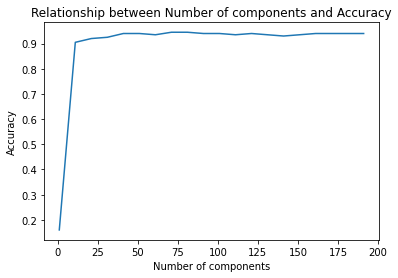

Randomized PCA Accuracy:	 0.94
Randomized PCA Time:	 1.1928571939468384
Shrinkage LDA Accuracy:	 0.985
Shrinkage LDA Time:	 598.3681540489197


In [ ]:
compute_accuracy_for_variations(training_data, training_labels, testing_data, testing_labels)

Time complexity and Accuracy comparison between PCA and Randomized PCA

In [ ]:
pca_time, pca_accuracies = [], []

for i in range(3):

  start_time = time.time()

  pca = PCA()
  pca.fit(training_data)

  projected_training_data = pca.project_data(training_data, 0.8)
  projected_testing_data = pca.project_data(testing_data, 0.8)
  _, accuracy = classifier(1, projected_training_data, training_labels,
                              projected_testing_data, testing_labels)

  end_time = time.time()

  pca_time.append(end_time - start_time)
  pca_accuracies.append(accuracy)

randomized_pca_time, randomized_pca_accuracies = [], []

for i in range(3):

  start_time = time.time()

  pca = PCA_Randomized(n_components=80,svd_solver='randomized')

  pca.fit(training_data)
  pca_projected_training_data = pca.transform(training_data)
  pca_projected_testing_data = pca.transform(testing_data)
  _, pca_accuracy = classifier(1, pca_projected_training_data, training_labels,
                            pca_projected_testing_data, testing_labels)

  end_time = time.time()

  randomized_pca_time.append(end_time - start_time)
  randomized_pca_accuracies.append(pca_accuracy)

print("PCA Time", np.mean(pca_time))
print("PCA Accuracy", np.mean(pca_accuracies))

print("Randomized PCA Time", np.mean(randomized_pca_time))
print("Randomized PCA Accuracy", np.mean(randomized_pca_accuracies))

PCA Time 321.3067455291748
PCA Accuracy 0.93
Randomized PCA Time 1.0312731266021729
Randomized PCA Accuracy 0.945


Time complexity and Accuracy comparison between LDA and Shrinkage LDA

In [ ]:
lda_time, lda_accuracies = [], []

for i in range(3):

  start_time = time.time()

  lda = LDA()
  lda.fit(training_data, training_labels, 39)
  projected_data = lda.project_data(training_data)
  projected_test_data = lda.project_data(testing_data)
  _, accuracy = classifier(1, projected_data, training_labels, projected_test_data, testing_labels)

  end_time = time.time()

  lda_time.append(end_time - start_time)
  lda_accuracies.append(accuracy)

shrinkage_lda_time, shrinkage_lda_accuracies = [], []

for i in range(3):

  start_time = time.time()

  shrinkage_lda = Shrinkage_LDA(solver='eigen', shrinkage='auto')
  shrinkage_lda.fit(training_data, training_labels)

  shrinkage_lda_training_data = shrinkage_lda.transform(training_data)
  shrinkage_lda_projected_testing_data = shrinkage_lda.transform(testing_data)
  _, shrinkage_lda_accuracy = classifier(1, shrinkage_lda_training_data, training_labels,
                           shrinkage_lda_projected_testing_data, testing_labels)

  end_time = time.time()

  shrinkage_lda_time.append(end_time - start_time)
  shrinkage_lda_accuracies.append(shrinkage_lda_accuracy)

print("LDA Time", np.mean(lda_time))
print("LDA Accuracy", np.mean(lda_accuracies))

print("Shrinkage LDA Time", np.mean(shrinkage_lda_time))
print("Shrinkage LDA Accuracy", np.mean(shrinkage_lda_accuracies))

LDA Time 1871.5823781490326
LDA Accuracy 0.96
Shrinkage LDA Time 559.4018071492513
Shrinkage LDA Accuracy 0.985
